Imports

In [1]:
from pvlib import solarposition
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True)
import matplotlib.pyplot as plt

Solar position

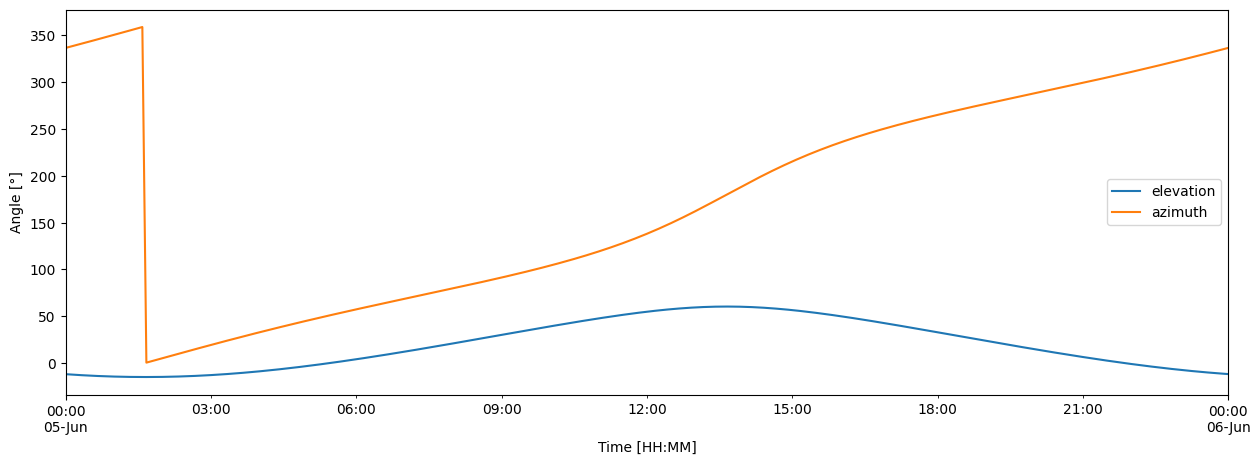

In [2]:
tz = 'CET'
lat, lon = 52.35850757579532, 4.881107791550871

# summer
start_date = '2022-06-05'
end_date = '2022-06-06'

# winter
# start_date = '2022-12-05'
# end_date = '2022-12-06'

times = pd.date_range(start=start_date, end=end_date, freq='5min', tz=tz)
solpos = solarposition.get_solarposition(times, lat, lon)

# plot of elevation and azimuth
plt.figure(figsize=(15, 5))
solpos['elevation'].plot(label='elevation')
solpos['azimuth'].plot(label='azimuth')
plt.ylabel('Angle [°]')
plt.xlabel('Time [HH:MM]')
plt.legend()
plt.show()

Calculate heights of blind

In [3]:
from numpy import cos, tan
from numpy import radians as rad

def calculate_blind_height(sol_elev: float, sol_azi: float, win_azi, azi_min, azi_max, d: float, h_def: float) -> np.ndarray:
    """
    Calculate the height of the blind based on the sun position and the panel tilt and azimuth.

    :param sol_elev: elevation of the sun in degrees
    :param sol_azi: azimuth of the sun in degrees
    :param win_azi: azimuth of the panel in degrees from north
    :param win_tilt: tilt of the panel in degrees
    :param d: distance between the working area and window facade in meters
    """
    # clip azi_min and azi_max to 90
    azi_min = min(azi_min, 90)
    azi_max = min(azi_max, 90)

    # surface solar azimuth
    gamma = (win_azi - sol_azi + 180) % 360 - 180

    # valid sun positions are those within the blind's azimuth range and above the horizon (FOV)
    valid = (gamma < azi_min) & (gamma > -azi_max) & (sol_elev > 0)

    # calculate blind height
    return np.where(valid, (d / cos(rad(gamma))) * tan(rad(sol_elev)), h_def), valid

Plot heights of blind

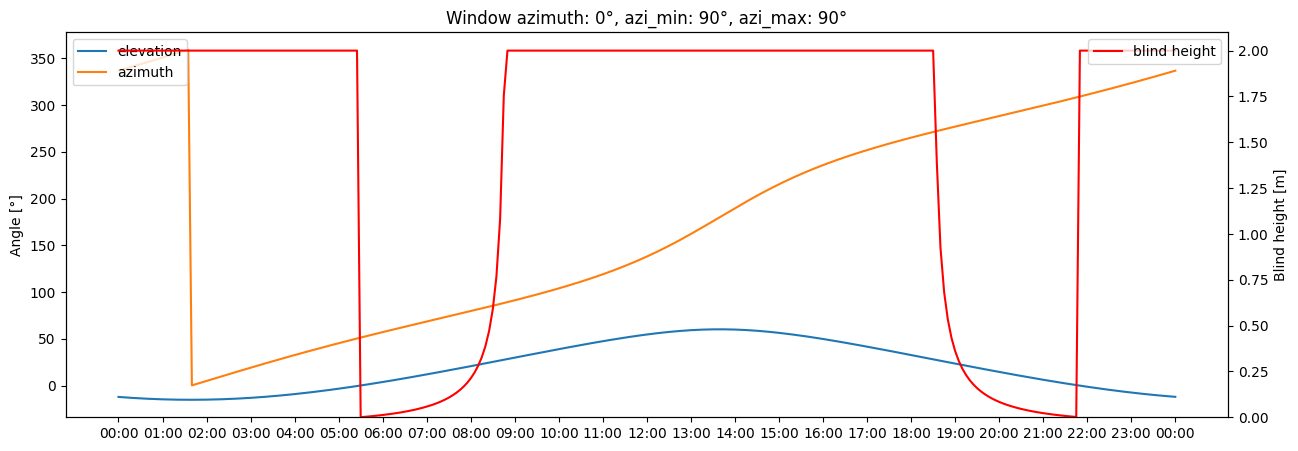

In [4]:
# variables
win_azi = 0
win_tilt = 0
h_max = 2.0
dis_workplane = 0.1
time = solpos.index

# azi min and max
azi_min = 90
azi_max = 90

# default height
h_def = 2.0

# calculate blind height and valid solpos
blind_height, valid = calculate_blind_height(solpos['elevation'], solpos['azimuth'], win_azi, azi_min=azi_min, azi_max=azi_max, d=dis_workplane, h_def=h_def)

# plot of blind height
ax, fig = plt.subplots(figsize=(15, 5))
plt.title(f"Window azimuth: {win_azi}°, azi_min: {azi_min}°, azi_max: {azi_max}°")
plt.plot(solpos['elevation'].values, label='elevation')
plt.plot(solpos['azimuth'].values, label='azimuth')
plt.legend(loc='upper left')
plt.ylabel('Angle [°]')

ax2 = fig.twinx()
ax2.plot(np.clip(blind_height, 0, h_max), label='blind height', color='red')
ax2.set_ylim(0, h_max + 0.1)
ax2.legend(loc='upper right')

plt.xticks(np.arange(0, len(time), 12), time[::12].strftime('%H:%M'), rotation=90)

# plt labels
plt.xlabel('Time [HH:MM]')
plt.ylabel('Blind height [m]')
plt.show()